Segments infection caused by pneumonia from MRI or CT scans of infected lungs.

Training data is sourced from kaggle and training is done in Google Colab. 
Due to the large size of each scan, training is done on smaller cropped sections of scans.

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 99% 1.02G/1.03G [00:29<00:00, 33.1MB/s]
100% 1.03G/1.03G [00:29<00:00, 37.5MB/s]


In [ ]:
!unzip -q '/content/covid19-ct-scans.zip'

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import nibabel as nib

import tensorflow as tf
import tensorflow.keras.backend as K

print(tf.__version__)

2.2.0


In [ ]:
metadata = pd.read_csv('/content/metadata.csv')

In [ ]:
base_dir_scan = '/content/ct_scans'
base_dir_infe = '/content/lung_mask'
path_trans_scan = lambda x: os.path.join(base_dir_scan, os.path.basename(x))
path_trans_infe = lambda x: os.path.join(base_dir_infe, os.path.basename(x))

metadata['ct_scan'] = metadata['ct_scan'].apply(path_trans_scan)
metadata['lung_mask'] = metadata['infection_mask'].apply(path_trans_infe)

In [ ]:
def readnii(filepath):
    ''' Reads nibabel file '''
    img = nib.load(filepath).get_fdata()
    img = np.rot90(img)
    return img

In [ ]:
def standardize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    arr_norm = (arr - mean) / (std + 1e-7)
    return arr_norm

In [ ]:
def get_generator(img_path, label_path, batch_size=8,
                  output_x=192, output_y=192, output_z=16):
    n = 0
    while True:
        if n == len(img_path):
            n = 0
        img = readnii(img_path[n])
        label = readnii(label_path[n])
        label = np.where(label==0, 0, 1)
        img = standardize(img)
        img_batch = []
        label_batch = []

        for i in range(batch_size):
            xx = np.random.randint(0, img.shape[0]-output_x)
            yy = np.random.randint(0, img.shape[1]-output_y)
            zz = np.random.randint(0, img.shape[2]-output_z)
            img3d = img[xx:xx+output_x,yy:yy+output_y,zz:zz+output_z]
            img_batch.append(img3d)
            label3d = label[xx:xx+output_x,yy:yy+output_y,zz:zz+output_z]
            label_batch.append(label3d)
        yield np.expand_dims(np.stack(img_batch, 0), -1), np.expand_dims(np.stack(label_batch, 0), -1)
        n+=1

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
fset_train, fset_valid, label_train, label_valid = train_test_split(scans, labels, test_size=0.25)

train_gen = get_generator(fset_train, label_train)
valid_gen = get_generator(fset_valid, label_valid)

In [ ]:
import time

start_time = time.time()
batch_x, batch_y = next(train_gen)
print(f'{time.time()-start_time} secs taken for execution')

5.637440204620361 secs taken for execution


In [ ]:
batch_x.shape, batch_y.shape

((8, 192, 192, 16, 1), (8, 192, 192, 16, 1))

In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    dice_numerator = 2 * K.sum(y_pred * y_true, axis=axis) + epsilon
    dice_denominator = K.sum(y_pred * y_pred, axis=axis) + K.sum(y_true * y_true, axis=axis) + epsilon
    dice_coefficient = K.mean(dice_numerator / dice_denominator)

    return dice_coefficient

def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    dice_numerator = 2 * K.sum(y_pred * y_true, axis=axis) + epsilon
    dice_denominator = K.sum(y_pred * y_pred, axis=axis) + K.sum(y_true * y_true, axis=axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)

    return dice_loss

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import *

Sample model 

In [ ]:
# def conv(input_layer, n, k=(3,3,3)):
#     x = Conv3D(n, k, padding='same', activation='relu')(input_layer)
#     x = Conv3D(n, k, padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
#     return x

# def create_model():
#     pool_size = (2,2,2)
#     inputs = Input(shape=(192, 192, 16, 1))
    
#     depth0 = conv(inputs, 32)
#     max0 = MaxPooling3D(pool_size)(depth0)

#     depth1 = conv(max0, 64)
#     max1 = MaxPooling3D(pool_size)(depth1)

#     depth2 = conv(max1, 128)
#     max2 = MaxPooling3D(pool_size)(depth2)

#     depth3 = conv(max2, 256)
#     max3 = MaxPooling3D(pool_size)(depth3)

#     depth4  = conv(max3, 256)

#     up3 = UpSampling3D(pool_size)(depth4)
#     concat3 = concatenate([up3, depth3], axis=-1)
#     up_depth3 = conv(concat3, 256)

#     up2 = UpSampling3D(pool_size)(up_depth3)
#     concat2 = concatenate([up2, depth2], axis=-1)
#     up_depth2 = conv(concat2, 128)

#     up1 = UpSampling3D(pool_size)(up_depth2)
#     concat1 = concatenate([up1, depth1], axis=-1)
#     up_depth1 = conv(concat1, 64)

#     up0 = UpSampling3D(pool_size)(up_depth1)
#     concat0 = concatenate([up0, depth0], axis=-1)
#     up_depth0 = conv(concat0,32)

#     final_layer = Conv3D(1, (1,1,1), padding='same', activation='sigmoid')(up_depth0)

#     model = Model(inputs=inputs, outputs=final_layer)

#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(loss=soft_dice_loss, optimizer=optimizer, metrics=[dice_coefficient])
#     return model

# model = create_model()
# model.summary()

Loading pre-trained model

In [ ]:
model = tf.keras.models.load_model('path/to/model', custom_objects={'soft_dice_loss':soft_dice_loss, 'dice_coefficient':dice_coefficient})

In [ ]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=soft_dice_loss, metrics=[dice_coefficient])

In [ ]:
def training(model, epochs=1, steps_per_epoch=15, filename='lung_mask_model'):
    checkpoint = ModelCheckpoint(f'path/to/{filename}.h5',
                                 save_best_only=True)
    lr = ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-7)
    earlyst = EarlyStopping(patience=10)

    history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, 
                        steps_per_epoch=steps_per_epoch, validation_steps=5,
                        callbacks=[checkpoint, lr, earlyst])
    return history

In [ ]:
history = training(model, 30, 15)

Epoch 1/30
15/15 [==============================] - 120s 8s/step - loss: 0.3194 - dice_coefficient: 0.6806 - val_loss: 0.4129 - val_dice_coefficient: 0.5871 - lr: 1.0000e-04
Epoch 2/30
15/15 [==============================] - 124s 8s/step - loss: 0.2857 - dice_coefficient: 0.7143 - val_loss: 0.3794 - val_dice_coefficient: 0.6206 - lr: 1.0000e-04
Epoch 3/30
15/15 [==============================] - 117s 8s/step - loss: 0.2876 - dice_coefficient: 0.7124 - val_loss: 0.3903 - val_dice_coefficient: 0.6097 - lr: 1.0000e-04
Epoch 4/30
15/15 [==============================] - 110s 7s/step - loss: 0.3277 - dice_coefficient: 0.6723 - val_loss: 0.3991 - val_dice_coefficient: 0.6009 - lr: 1.0000e-04
Epoch 5/30
15/15 [==============================] - 121s 8s/step - loss: 0.3188 - dice_coefficient: 0.6812 - val_loss: 0.3606 - val_dice_coefficient: 0.6394 - lr: 5.0000e-05
Epoch 6/30
15/15 [==============================] - 71s 5s/step - loss: 0.2484 - dice_coefficient: 0.7516 - val_loss: 0.4157 - val

In [ ]:
xv, yv = next(valid_gen)

preds = model.predict(xv)

In [ ]:
# for i in range(6):
#   depth = 15 # should be less than 16
#   fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,10))
#   ax1.imshow(xv[i][:,:,depth,0], cmap='gray')
#   ax2.imshow(yv[i][:,:,depth,0], cmap='gray')
#   ax3.imshow(preds[i][:,:,depth,0], cmap='gray')
#   ax1.set_title('Scan')
#   ax2.set_title('Ground Truth')
#   ax3.set_title('Prediction')

In [ ]:
import imageio
from IPython.display import Image
import cv2

In [ ]:
def norm(image):

    image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)
    return image

Create a gif of prediction and ground truth labels superimposed on scan

In [ ]:
def visualize_data_gif(scan, gt, pred, name):
    images = []
    for i in range(scan.shape[2]):
        img_scan = scan[:, :, i]
        img_gt = gt[:,:,i]
        img_p = pred[:,:,i]
        pred_plus = np.where(img_scan>img_p, img_scan, img_p)
        pred_minus = np.where(img_p<122, img_scan, 0)
        img_pred = np.stack([pred_plus, pred_plus, pred_minus], axis=2)
        red = np.where((img_gt==0) & (img_p>0), img_p, 0)
        blue = np.where((img_gt==255) & (img_p<122), 255, 0)
        green = np.where((img_gt==255) & (img_p>122), 255, 0)
        gt_pred = np.stack([red, green, blue], axis=2).astype(np.uint8)
        gap = 255*np.ones_like(img_pred[:,0:20]).astype(np.uint8)
        img = np.concatenate([img_pred, gap, gt_pred], axis=1)
        images.append(img)
    imageio.mimsave(f"/content/{name}.gif", images, duration=0.5)
    return Image(filename=f"/content//{name}.gif", format='png', width=600, height=300)

*Green - True positive*<br>
*Red - False Positive*<br>
*Blue - False Negative*<br>
*Black - True Negative*<br>
*Yellow - Prediction (TP + FP)*

In [ ]:
xv, yv = next(valid_gen)
preds = model.predict(xv)

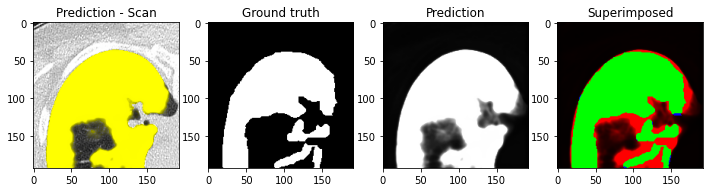

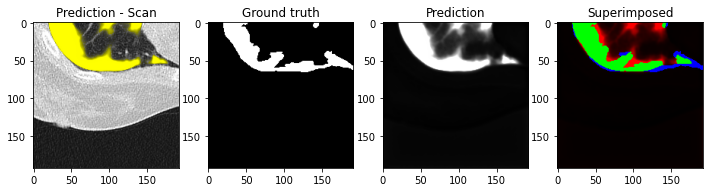

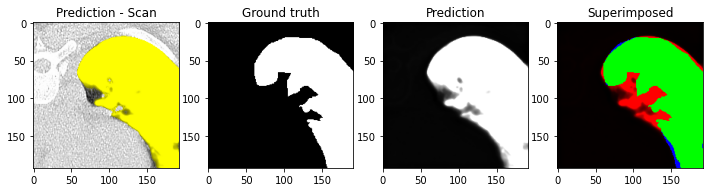

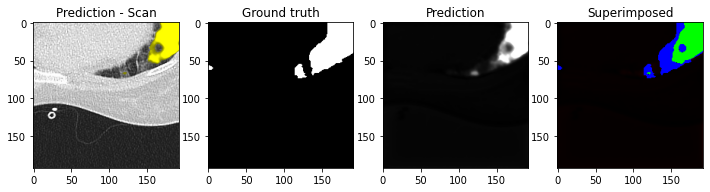

In [ ]:
for i in range(xv.shape[0]):
  img_scan = norm(xv[i])[:,:,8]
  img_p = norm(preds[i])[:,:,8]
  img_gt = norm(yv[i])[:,:,8]
  pred_plus = np.where(img_scan>img_p, img_scan, img_p)
  pred_minus = np.where(img_p<122, img_scan, 0)
  img_pred = np.stack([pred_plus, pred_plus, pred_minus], axis=2)
  red = np.where((img_gt==0) & (img_p>0), img_p, 0)
  blue = np.where((img_gt==255) & (img_p<122), 255, 0)
  green = np.where((img_gt==255) & (img_p>122), 255, 0)
  gt_pred = np.stack([red, green, blue], axis=2).astype(np.uint8)
  fig, (ax4, ax3, ax2, ax1) = plt.subplots(1, 4, figsize=(12, 12))
  ax1.imshow(gt_pred)
  ax2.imshow(img_p, cmap='gray')
  ax3.imshow(img_gt, 'gray')
  ax4.imshow(img_pred)

  ax1.set_title('Superimposed')
  ax2.set_title('Prediction')
  ax3.set_title('Ground truth')
  ax4.set_title('Prediction - Scan')

In [ ]:
def visualize_full_img(x, y, preds, name):
    ''' Full scan visulaization '''
    xx1 = np.concatenate([x[0], x[1]], axis=0)
    xx2 = np.concatenate([x[2], x[3]], axis=0)
    xx3 = np.concatenate([xx1, xx2], axis=1)

    yy1 = np.concatenate([y[0], y[1]], axis=0)
    yy2 = np.concatenate([y[2], y[3]], axis=0)
    yy3 = np.concatenate([yy1, yy2], axis=1)

    pred1 = np.concatenate([preds[0], preds[1]], axis=0)
    pred2 = np.concatenate([preds[2], preds[3]], axis=0)
    pred3 = np.concatenate([pred1, pred2], axis=1)

    img = norm(xx3)
    gt = norm(yy3)
    pred = norm(pred3)

    return visualize_data_gif(img, gt, pred, name)

In [ ]:
for i in range(5):
    xv, yv = next(valid_gen)
    preds = model.predict(xv)
    visualize_full_img(xv, yv, preds, f'gif{str(i)}')

Predictions done on sections of scans are joined together to visualize the entire scan

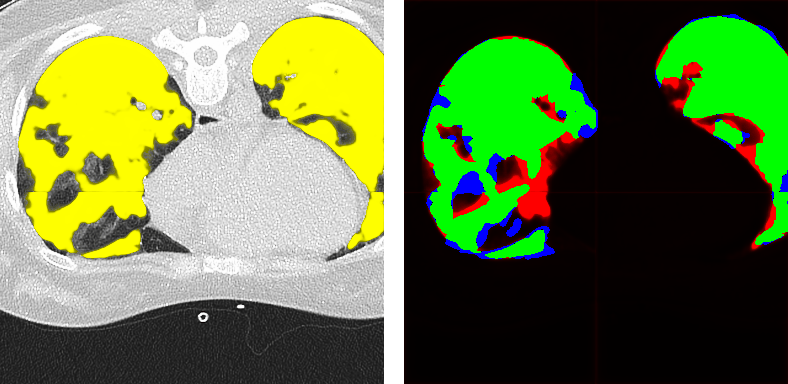

In [ ]:
Image(filename="/content/gif0.gif", format='png', width=600, height=300)